# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 9

try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter9()

In [1]:
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *

In [2]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

from data_generation.square_sequences import generate_sequences
from stepbystep.v4 import StepByStep

# Part I

# Sequence-to-Sequence

## Data Generation

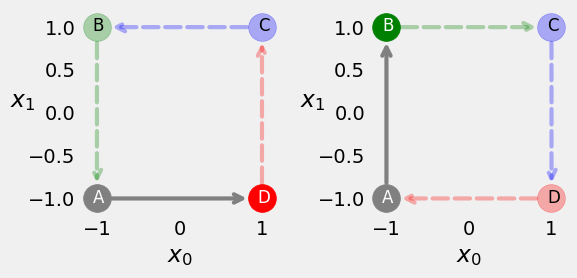

In [3]:
fig = counter_vs_clock(binary=False)

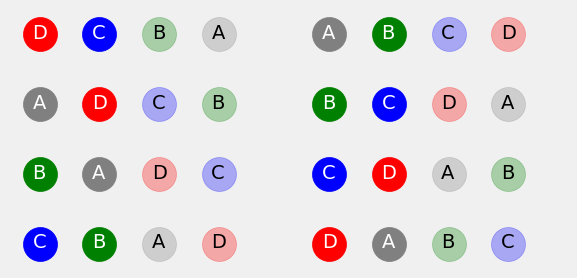

In [4]:
fig = plot_sequences(binary=False, target_len=2)

In [5]:
points, directions = generate_sequences(n=256, seed=13)

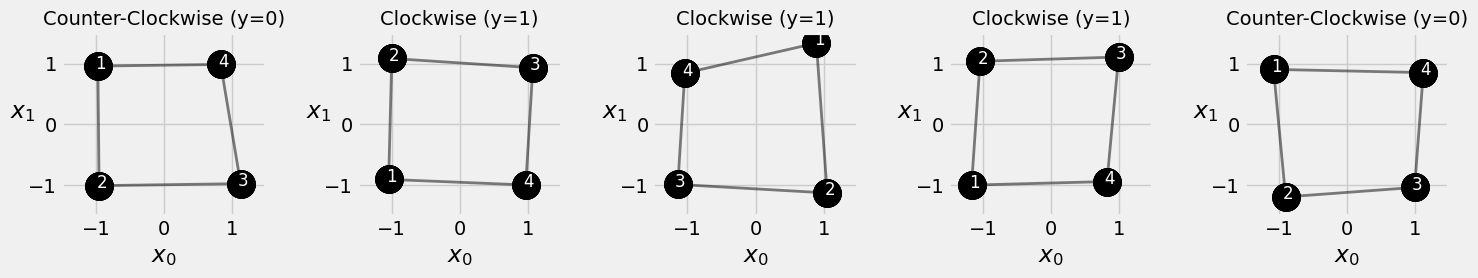

In [6]:
fig = plot_data(points, directions, n_rows=1)

## Encoder-Decoder Architecture

### Encoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoder.png?raw=1)

In [7]:
class Encoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
                
    def forward(self, X):        
        rnn_out, self.hidden = self.basic_rnn(X)
        
        return rnn_out # N, L, F

In [8]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2] # first two corners
target_seq = full_seq[:, 2:] # last two corners

In [9]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq) # output is N, L, F
hidden_final = hidden_seq[:, -1:]   # takes last hidden state
hidden_final

tensor([[[ 0.3105, -0.5263]]], grad_fn=<SliceBackward0>)

### Decoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/decoder.png?raw=1)

In [10]:
class Decoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True) 
        self.regression = nn.Linear(self.hidden_dim, self.n_features)
        
    def init_hidden(self, hidden_seq):
        # We only need the final hidden state
        hidden_final = hidden_seq[:, -1:] # N, 1, H
        # But we need to make it sequence-first
        self.hidden = hidden_final.permute(1, 0, 2) # 1, N, H                      
        
    def forward(self, X):
        # X is N, 1, F
        batch_first_output, self.hidden = self.basic_rnn(X, self.hidden) 
        
        last_output = batch_first_output[:, -1:]
        out = self.regression(last_output)
        
        # N, 1, F
        return out.view(-1, 1, self.n_features)               

In [11]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)

# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs)   # Predicts coordinates
    print(f'Output: {out}\n')
    # Predicted coordinates are next step's inputs
    inputs = out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward0>)



#### Teacher Forcing

In [12]:
# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs) # Predicts coordinates    
    print(f'Output: {out}\n')
    # But completely ignores the predictions and uses real data instead
    inputs = target_seq[:, i:i+1]

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[0.2265, 0.4529]]], grad_fn=<ViewBackward0>)



In [13]:
# Initial hidden state is encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

teacher_forcing_prob = 0.5
target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs)
    print(f'Output: {out}\n')
    # If it is teacher forcing
    if torch.rand(1) <= teacher_forcing_prob:
        # Takes the actual element
        inputs = target_seq[:, i:i+1]
    else:
        # Otherwise uses the last predicted output
        inputs = out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward0>)



### Encoder + Decoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoder_decoder.png?raw=1)

In [14]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.teacher_forcing_prob = teacher_forcing_prob
        self.outputs = None
        
    def init_outputs(self, batch_size):
        device = next(self.parameters()).device
        # N, L (target), F
        self.outputs = torch.zeros(batch_size, 
                              self.target_len, 
                              self.encoder.n_features).to(device)
    
    def store_output(self, i, out):
        # Stores the output
        self.outputs[:, i:i+1, :] = out
        
    def forward(self, X):               
        # splits the data in source and target sequences
        # the target seq will be empty in testing mode
        # N, L, F
        source_seq = X[:, :self.input_len, :]
        target_seq = X[:, self.input_len:, :]
        self.init_outputs(X.shape[0])        
        
        # Encoder expected N, L, F
        hidden_seq = self.encoder(source_seq)
        # Output is N, L, H
        self.decoder.init_hidden(hidden_seq)
        
        # The last input of the encoder is also
        # the first input of the decoder
        dec_inputs = source_seq[:, -1:, :]
        
        # Generates as many outputs as the target length
        for i in range(self.target_len):
            # Output of decoder is N, 1, F
            out = self.decoder(dec_inputs)
            self.store_output(i, out)
            
            prob = self.teacher_forcing_prob
            # In evaluation/test the target sequence is
            # unknown, so we cannot use teacher forcing
            if not self.training:
                prob = 0
                
            # If it is teacher forcing
            if torch.rand(1) <= prob:
                # Takes the actual element
                dec_inputs = target_seq[:, i:i+1, :]
            else:
                # Otherwise uses the last predicted output
                dec_inputs = out
            
        return self.outputs

In [15]:
encdec = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=1.0)

In [16]:
encdec.train()
encdec(full_seq)

tensor([[[-0.2339,  0.4702],
         [ 0.2265,  0.4529]]], grad_fn=<CopySlices>)

In [17]:
encdec.eval()
encdec(source_seq)

tensor([[[-0.2339,  0.4702],
         [-0.0226,  0.4628]]], grad_fn=<CopySlices>)

### Data Preparation

In [18]:
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]

/var/folders/74/v7qc979j2z7d9j_wsymkmkrc0000gn/T/ipykernel_14334/1483810553.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  full_train = torch.as_tensor(points).float()


In [19]:
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

In [20]:
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

### Model Training & Configuration

In [21]:
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder = Decoder(n_features=2, hidden_dim=2)
model = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
sbs_seq = StepByStep(model, loss, optimizer)
sbs_seq.set_loaders(train_loader, test_loader)
sbs_seq.train(100)

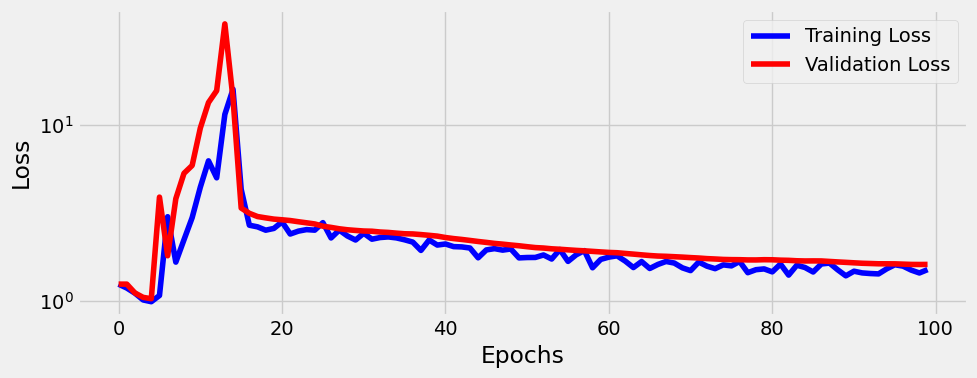

In [23]:
fig = sbs_seq.plot_losses()

### Visualizing Predictions

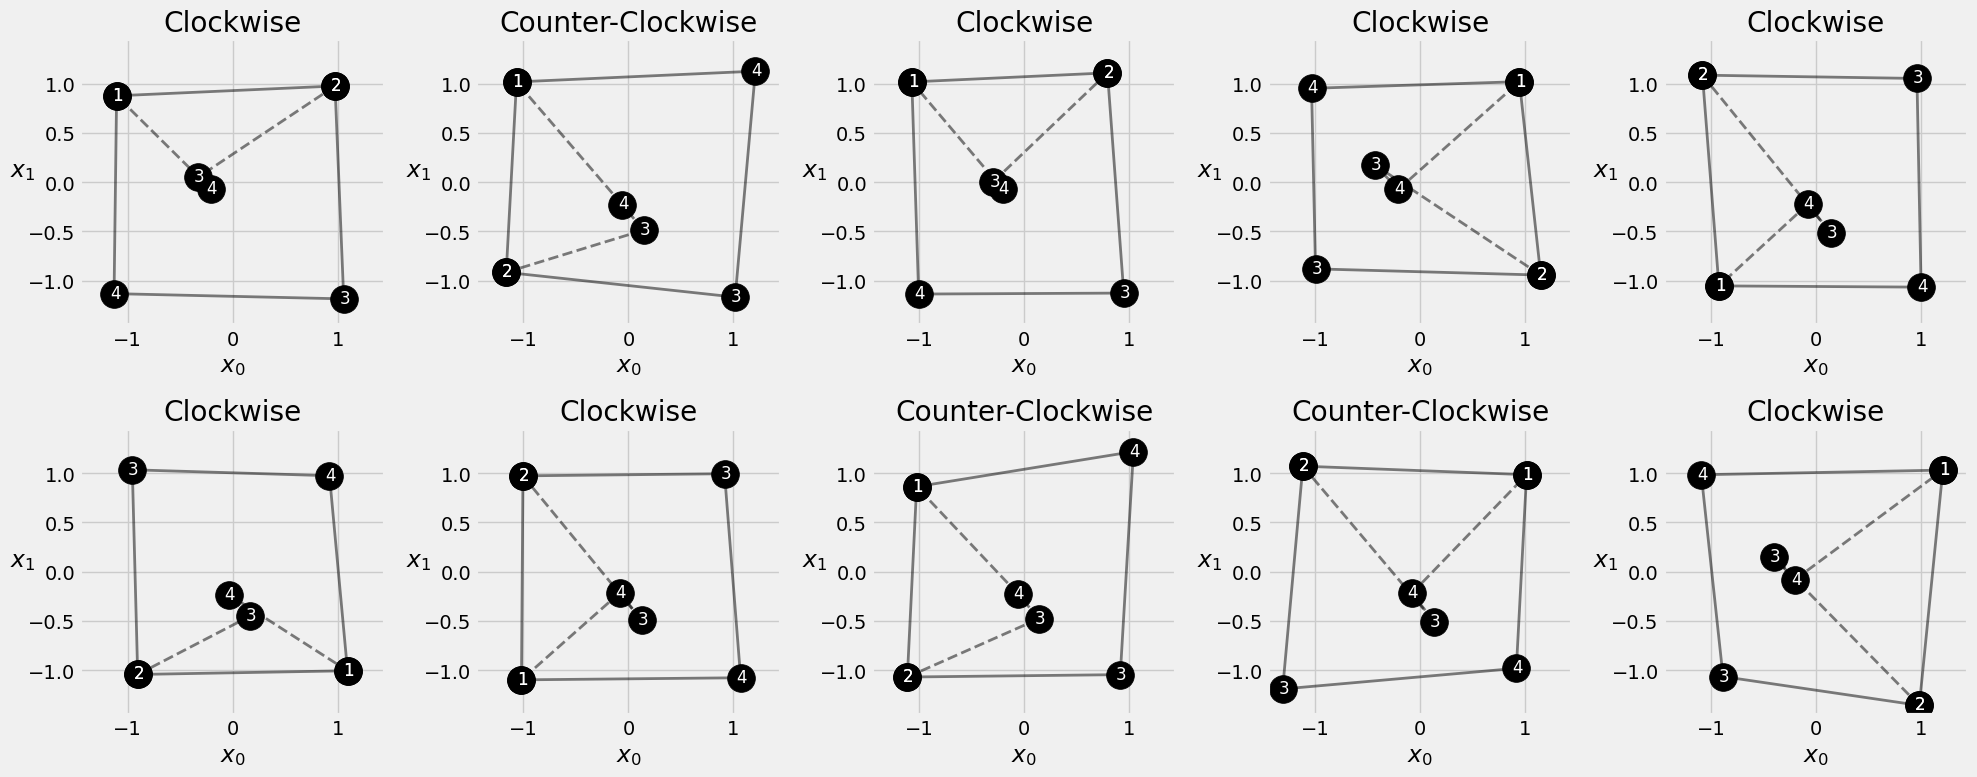

In [24]:
fig = sequence_pred(sbs_seq, full_test, test_directions)

## Attention

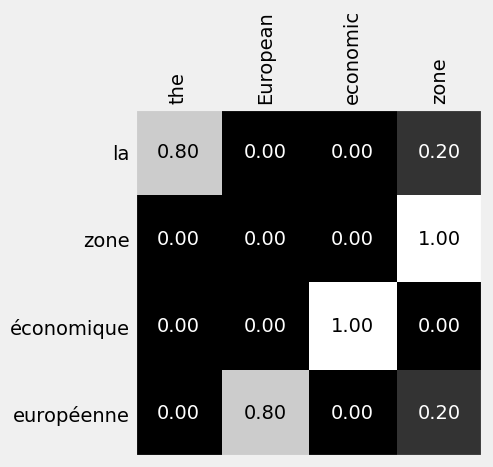

In [25]:
fig = figure9()

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/enc_dec_attn_translate.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/context_translate.png?raw=1)

### "Values"

$$
\large
\text{context vector} = \underbrace{\alpha_0 * h_0}_{\text{alignment vector}_0} + \underbrace{\alpha_1 * h_1}_{\text{alignment vector}_1} = 0.8 * \text{value}_{the} + 0.2 *\text{value}_{zone}
$$

### "Keys" and "Queries"

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/kq_matches.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/score_alignment_translate.png?raw=1)

### Computing the Context Vector

In [26]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [27]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq)

values = hidden_seq # N, L, H
values

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [28]:
keys = hidden_seq # N, L, H
keys

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [29]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)
decoder.init_hidden(hidden_seq)

inputs = source_seq[:, -1:]
out = decoder(inputs)

In [30]:
query = decoder.hidden.permute(1, 0, 2)  # N, 1, H
query

tensor([[[ 0.3913, -0.6853]]], grad_fn=<PermuteBackward0>)

In [31]:
def calc_alphas(ks, q):
    N, L, H = ks.size()
    alphas = torch.ones(N, 1, L).float() * 1/L
    return alphas

alphas = calc_alphas(keys, query)
alphas

tensor([[[0.5000, 0.5000]]])

$$
\Large
(\color{green}{N}\color{black}, 1, \color{red}{L}\color{black}) \times 
(\color{green}{N}\color{black}, \color{red}{L}\color{black}, H) = 
(\color{green}{N}\color{black}, 1\color{black}, H)
$$

In [32]:
# N, 1, L x N, L, H -> 1, L x L, H -> 1, H
context_vector = torch.bmm(alphas, values)
context_vector

tensor([[[ 0.1968, -0.2809]]], grad_fn=<BmmBackward0>)

In [33]:
concatenated = torch.cat([context_vector, query], axis=-1)
concatenated

tensor([[[ 0.1968, -0.2809,  0.3913, -0.6853]]], grad_fn=<CatBackward0>)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encdec_attn.png?raw=1)

### Scoring Method

$$
\Large
\text{cos}\ \theta = \frac{\sum_i{q_ik_i}}{\sqrt{\sum_j{q_j^2}}\sqrt{\sum_j{k_j^2}}}
$$

$$
\Large
\text{cos}\ \theta \sqrt{\sum_j{q_j^2}}\sqrt{\sum_j{k_j^2}}= \sum_i{q_ik_i}
$$

$$
\Large
\text{cos}\ \theta\ ||Q||\ ||K|| = Q \cdot K
$$

In [34]:
# N, 1, H x N, H, L -> N, 1, L
products = torch.bmm(query, keys.permute(0, 2, 1))
products

tensor([[[0.0569, 0.4821]]], grad_fn=<BmmBackward0>)

### Attention Scores

In [35]:
alphas = F.softmax(products, dim=-1)
alphas

tensor([[[0.3953, 0.6047]]], grad_fn=<SoftmaxBackward0>)

In [36]:
def calc_alphas(ks, q):
    # N, 1, H x N, H, L -> N, 1, L
    products = torch.bmm(q, ks.permute(0, 2, 1))
    alphas = F.softmax(products, dim=-1)    
    return alphas

### Visualizing the Context Vector

In [37]:
q = torch.tensor([.55, .95]).view(1, 1, 2) # N, 1, H
k = torch.tensor([[.65, .2], 
                  [.85, -.4], 
                  [-.95, -.75]]).view(1, 3, 2) # N, L, H

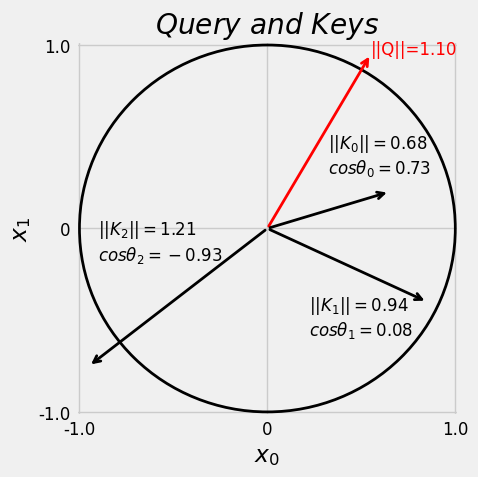

In [38]:
fig = query_and_keys(q.squeeze(), k.view(3, 2))

$$
\Large
\begin{array}
&Q \cdot K_0 = cos \theta_0\ ||Q||\ ||K_0|| =& &0.73 &*& 1.10 &*& 0.68 =& &0.54
\\
Q \cdot K_1 = cos \theta_1\ ||Q||\ ||K_1|| =& &0.08 &*& 1.10 &*& 0.94 =& &0.08
\\
Q \cdot K_2 = cos \theta_2\ ||Q||\ ||K_2|| =& -&0.93 &*& 1.10 &*& 1.21 =& -&1.23
\end{array}
$$

In [39]:
# N, 1, H x N, H, L -> N, 1, L
prod = torch.bmm(q, k.permute(0, 2, 1))
prod

tensor([[[ 0.5475,  0.0875, -1.2350]]])

In [40]:
scores = F.softmax(prod, dim=-1)
scores

tensor([[[0.5557, 0.3508, 0.0935]]])

$$
\Large
\text{context vector}=
0.5557*
\begin{bmatrix}
0.65
\\
0.20
\end{bmatrix}
+
0.3508*
\begin{bmatrix}
\ \ 0.85
\\
-0.40
\end{bmatrix}
+
0.0935*
\begin{bmatrix}
-0.95
\\
-0.75
\end{bmatrix}
$$

In [41]:
v = k
context = torch.bmm(scores, v)
context

tensor([[[ 0.5706, -0.0993]]])

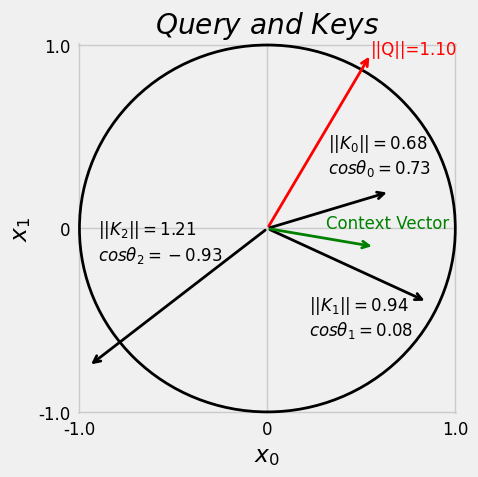

In [42]:
fig = query_and_keys(q.squeeze(), k.view(3, 2), context)

### Scaled Dot Product

$$
\Large
\text{scaled dot product} = \frac{Q \cdot K}{\sqrt{d_k}}
$$

In [43]:
dims = query.size(-1)
scaled_products = products / np.sqrt(dims)
scaled_products

tensor([[[0.0403, 0.3409]]], grad_fn=<DivBackward0>)

In [44]:
dummy_product = torch.tensor([4.0, 1.0])
F.softmax(dummy_product, dim=-1), F.softmax(100*dummy_product, dim=-1)

(tensor([0.9526, 0.0474]), tensor([1., 0.]))

In [45]:
alphas = F.softmax(scaled_products, dim=-1)
alphas

tensor([[[0.4254, 0.5746]]], grad_fn=<SoftmaxBackward0>)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/aiayn_dot.png?raw=1)

In [46]:
n_dims = 10
vector1 = torch.randn(10000, 1, n_dims)
vector2 = torch.randn(10000, 1, n_dims).permute(0, 2, 1)
torch.bmm(vector1, vector2).squeeze().var()

tensor(9.7670)

$$
\Large
\text{Var}(\text{vector}_1 \cdot \text{vector}_2) = d_{\text{vector}_1} = d_{\text{vector}_1}
\\
\Large
\sigma(\text{vector}_1 \cdot \text{vector}_2) = \sqrt{d_{\text{vector}_1}} = \sqrt{d_{\text{vector}_2}}
$$

In [47]:
def calc_alphas(ks, q):
    dims = q.size(-1)
    # N, 1, H x N, H, L -> N, 1, L
    products = torch.bmm(q, ks.permute(0, 2, 1))
    scaled_products = products / np.sqrt(dims)
    alphas = F.softmax(scaled_products, dim=-1)    
    return alphas

In [48]:
alphas = calc_alphas(keys, query)
# N, 1, L x N, L, H -> 1, L x L, H -> 1, H
context_vector = torch.bmm(alphas, values)
context_vector

tensor([[[ 0.2138, -0.3175]]], grad_fn=<BmmBackward0>)

### Attention Mechanism

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/attention.png?raw=1)

In [49]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        # Affine transformations for Q, K, and V
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None
                
    def init_keys(self, keys):
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) \
                      if self.proj_values else self.keys
                
    def score_function(self, query):
        proj_query = self.linear_query(query)
        # scaled dot product
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def forward(self, query, mask=None):
        # Query is batch-first N, 1, H
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()
        
        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

### Source Mask

In [50]:
source_seq = torch.tensor([[[-1., 1.], [0., 0.]]])
# pretend there's an encoder here...
keys = torch.tensor([[[-.38, .44], [.85, -.05]]])
query = torch.tensor([[[-1., 1.]]])

In [51]:
source_mask = (source_seq != 0).all(axis=2).unsqueeze(1)
source_mask # N, 1, L

tensor([[[ True, False]]])

In [52]:
torch.manual_seed(11)
attnh = Attention(2)
attnh.init_keys(keys)

context = attnh(query, mask=source_mask)
attnh.alphas

tensor([[[1., 0.]]])

### Decoder

In [53]:
class DecoderAttn(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True) 
        self.attn = Attention(self.hidden_dim)
        self.regression = nn.Linear(2 * self.hidden_dim, self.n_features)
        
    def init_hidden(self, hidden_seq):
        # the output of the encoder is N, L, H
        # and init_keys expects batch-first as well
        self.attn.init_keys(hidden_seq)
        hidden_final = hidden_seq[:, -1:]
        self.hidden = hidden_final.permute(1, 0, 2)   # L, N, H                      
        
    def forward(self, X, mask=None):
        # X is N, 1, F
        batch_first_output, self.hidden = self.basic_rnn(X, self.hidden) 
        
        query = batch_first_output[:, -1:]
        # Attention 
        context = self.attn(query, mask=mask)
        concatenated = torch.cat([context, query], axis=-1)
        out = self.regression(concatenated)
        
        # N, 1, F
        return out.view(-1, 1, self.n_features)

In [54]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [55]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder_attn = DecoderAttn(n_features=2, hidden_dim=2)

# Generates hidden states (keys and values)
hidden_seq = encoder(source_seq)
decoder_attn.init_hidden(hidden_seq)

# Target sequence generation
inputs = source_seq[:, -1:]
target_len = 2
for i in range(target_len):
    out = decoder_attn(inputs)
    print(f'Output: {out}')    
    inputs = out

Output: tensor([[[-0.3555, -0.1220]]], grad_fn=<ViewBackward0>)
Output: tensor([[[-0.2641, -0.2521]]], grad_fn=<ViewBackward0>)


### Encoder + Decoder + Attention

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encdec_attn.png?raw=1)

In [56]:
encdec = EncoderDecoder(encoder, decoder_attn, input_len=2, target_len=2, teacher_forcing_prob=0.0)
encdec(full_seq)

tensor([[[-0.3555, -0.1220],
         [-0.2641, -0.2521]]], grad_fn=<CopySlices>)

In [57]:
class EncoderDecoderAttn(EncoderDecoder):
    def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
        super().__init__(encoder, decoder, input_len, target_len, teacher_forcing_prob)
        self.alphas = None
        
    def init_outputs(self, batch_size):
        device = next(self.parameters()).device
        # N, L (target), F
        self.outputs = torch.zeros(batch_size, 
                              self.target_len, 
                              self.encoder.n_features).to(device)
        # N, L (target), L (source)
        self.alphas = torch.zeros(batch_size, 
                                  self.target_len, 
                                  self.input_len).to(device)
        
    def store_output(self, i, out):
        # Stores the output
        self.outputs[:, i:i+1, :] = out
        self.alphas[:, i:i+1, :] = self.decoder.attn.alphas

### Model Configuration & Training

In [58]:
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder_attn = DecoderAttn(n_features=2, hidden_dim=2)
model = EncoderDecoderAttn(encoder, decoder_attn, input_len=2, target_len=2, teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [59]:
sbs_seq_attn = StepByStep(model, loss, optimizer)
sbs_seq_attn.set_loaders(train_loader, test_loader)
sbs_seq_attn.train(100)

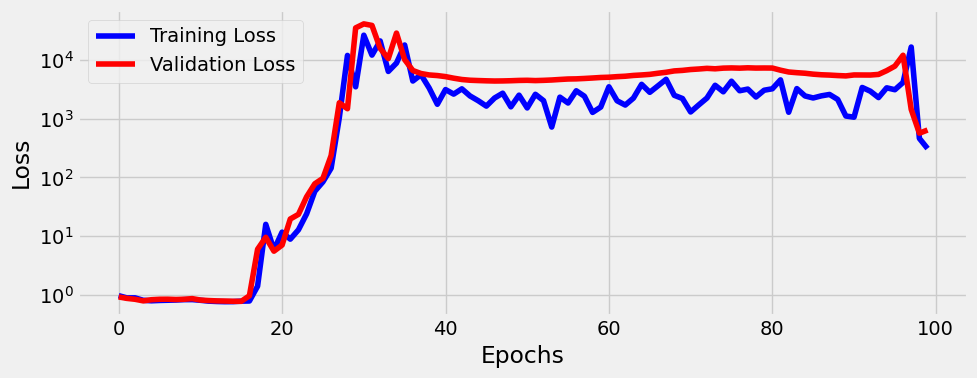

In [60]:
fig = sbs_seq_attn.plot_losses()

### Visualizing Predictions

/Users/norman/Data Science/PyTorchStepByStep/plots/chapter9.py:83: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


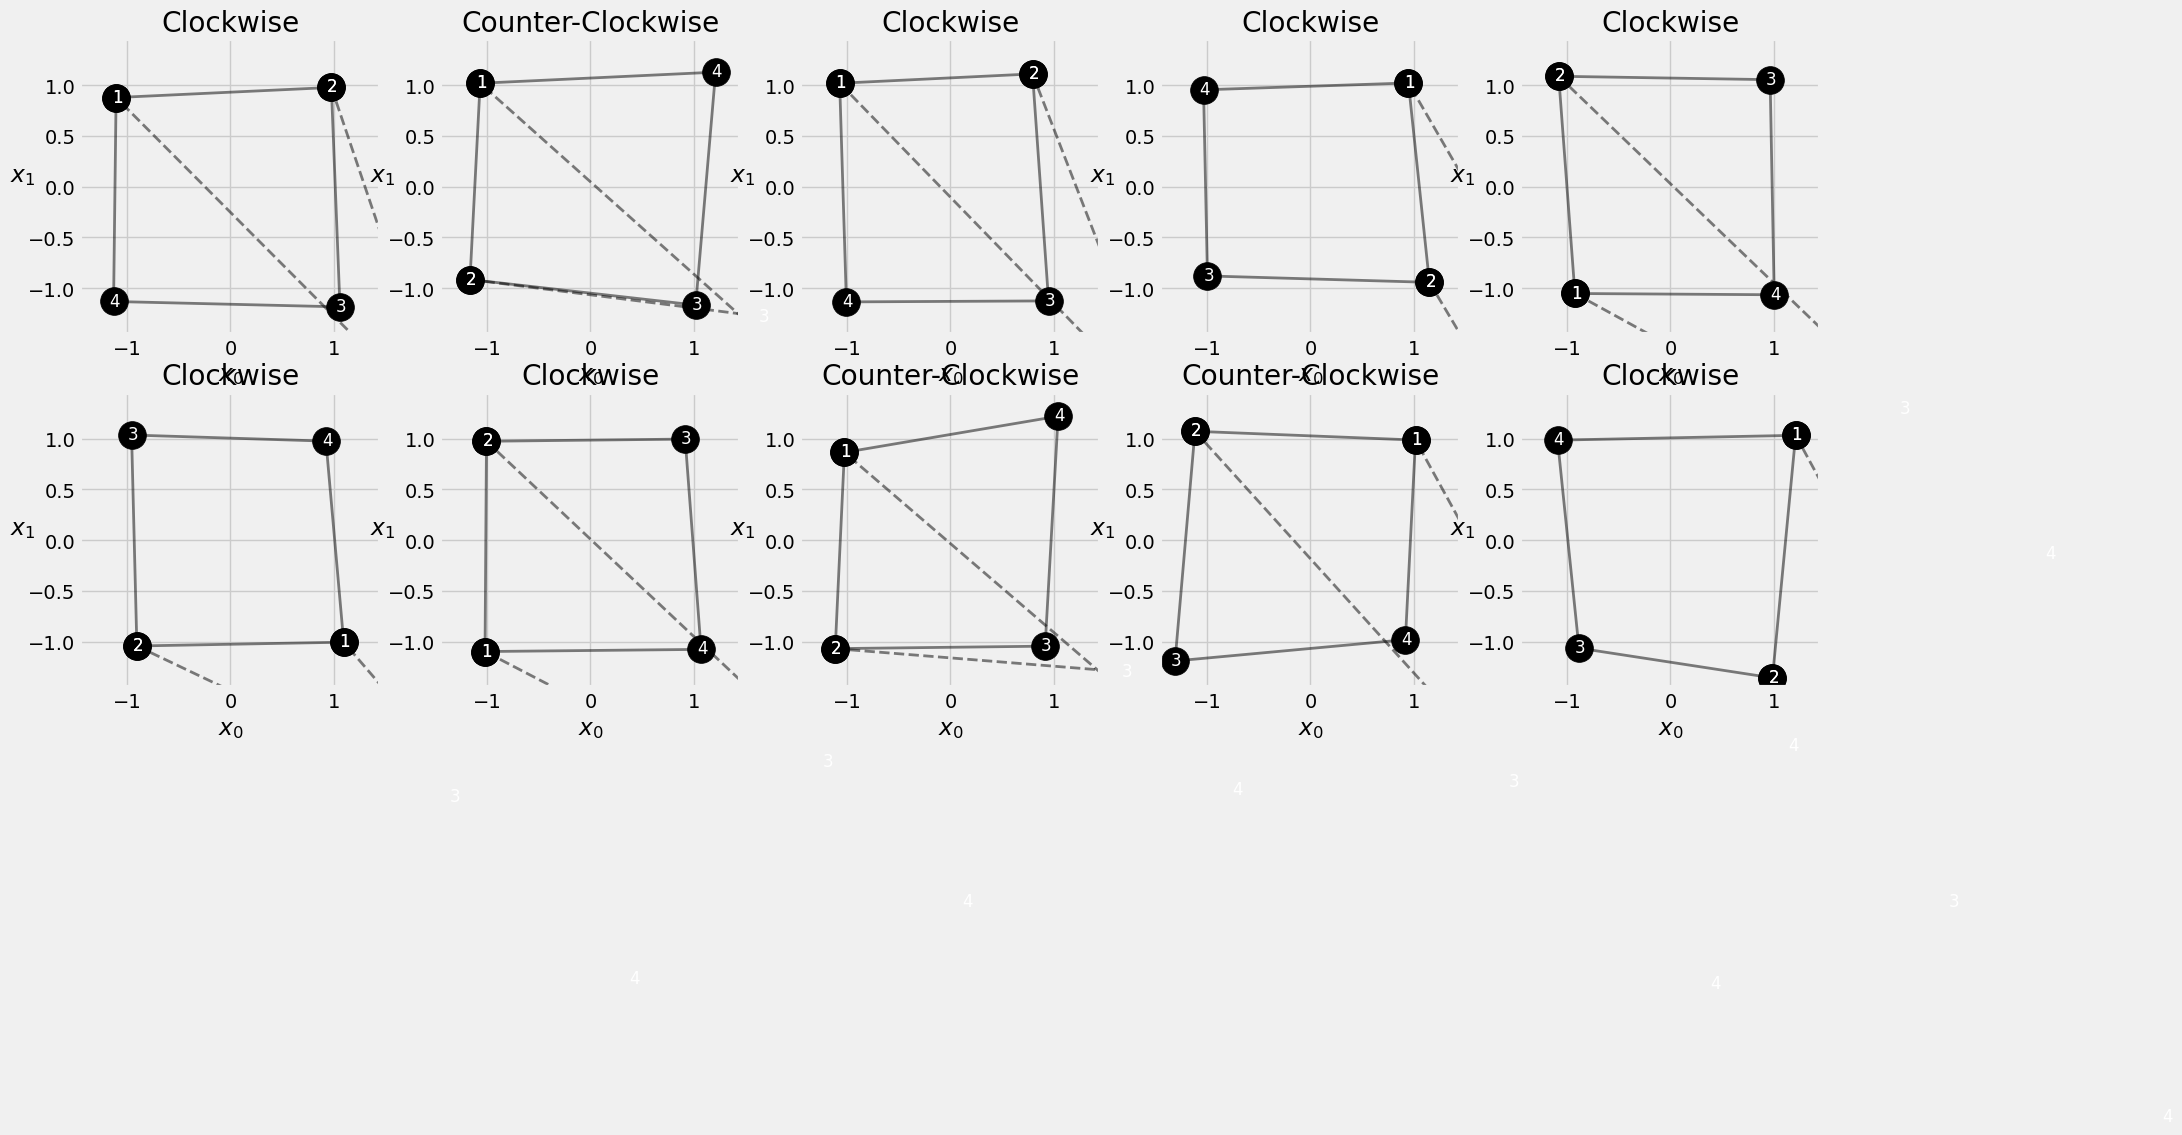

In [61]:
fig = sequence_pred(sbs_seq_attn, full_test, test_directions)

### Visualizing Attention

In [62]:
inputs = full_train[:1, :2]
out = sbs_seq_attn.predict(inputs)
sbs_seq_attn.model.alphas

tensor([[[0.3563, 0.6437],
         [0.3533, 0.6467]]], device='mps:0')

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{green}{x_2} & \alpha_{\color{green}{2}\color{red}0} & \alpha_{{\color{green}{2}\color{red}1}} \\
 \color{green}{x_3} & \alpha_{\color{green}{3}\color{red}0} & \alpha_{{\color{green}{3}\color{red}1}}
\end{array}
\implies
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{green}{x_2} & 0.8196 & 0.1804\\
 \color{green}{x_3} & 0.7316 & 0.2684
\end{array}
$$

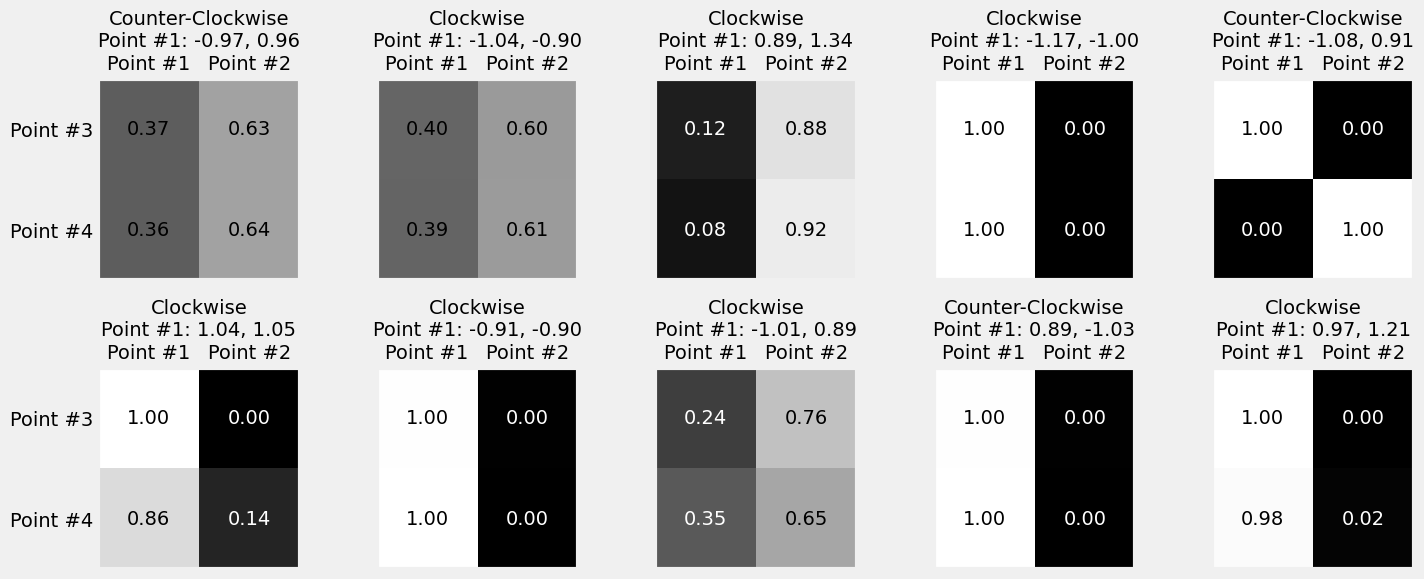

In [63]:
inputs = full_train[:10, :2]
source_labels = ['Point #1', 'Point #2']
target_labels = ['Point #3', 'Point #4']
point_labels = [f'{"Counter-" if not directions[i] else ""}Clockwise\nPoint #1: {inp[0, 0]:.2f}, {inp[0, 1]:.2f}' for i, inp in enumerate(inputs)]
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels)

### Multi-Headed Attention

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/multiattn.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/aiayn_multihead.png?raw=1)

In [64]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out = nn.Linear(n_heads * d_model, d_model)
        self.attn_heads = nn.ModuleList([Attention(d_model, 
                                                   input_dim=input_dim, 
                                                   proj_values=proj_values) 
                                         for _ in range(n_heads)])
        
    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)
        
    @property
    def alphas(self):
        # Shape: n_heads, N, 1, L (source)
        return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)
        
    def output_function(self, contexts):
        # N, 1, n_heads * D
        concatenated = torch.cat(contexts, axis=-1)
        # Linear transf. to go back to original dimension
        out = self.linear_out(concatenated) # N, 1, D
        return out
        
    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out

# Part II

## Self-Attention

### Encoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoder_self.png?raw=1)

$$
\Large
\alpha_{\color{blue}{0}\color{red}0}, \alpha_{{\color{blue}{0}\color{red}1}} = \text{softmax}(\frac{\color{red}{Q_0}\color{black}\cdot K_0}{\sqrt{2}}, \frac{\color{red}{Q_0}\color{black}\cdot K_1}{\sqrt{2}})
\\
\Large
\color{blue}{\text{context vector}_0}\color{black}= \alpha_{\color{blue}{0}\color{red}0}V_0 + \alpha_{{\color{blue}{0}\color{red}1}}V_1
$$

$$
\Large
\alpha_{\color{blue}{1}\color{red}0}, \alpha_{{\color{blue}{1}\color{red}1}} = \text{softmax}(\frac{\color{red}{Q_1}\color{black}\cdot K_0}{\sqrt{2}}, \frac{\color{red}{Q_1}\color{black}\cdot K_1}{\sqrt{2}})
\\
\Large
\color{blue}{\text{context vector}_1}\color{black}= \alpha_{\color{blue}{1}\color{red}0}V_0 + \alpha_{{\color{blue}{1}\color{red}1}}V_1
$$

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{blue}{h_0} & \alpha_{\color{blue}{0}\color{red}0} & \alpha_{{\color{blue}{0}\color{red}1}} \\
 \color{blue}{h_1} & \alpha_{\color{blue}{1}\color{red}0} & \alpha_{{\color{blue}{1}\color{red}1}}
\end{array}
$$

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/transf_encself.png?raw=1)

In [65]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=n_features)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model),
        )
         
    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att = self.self_attn_heads(query, mask)
        out = self.ffn(att)
        return out

In [66]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [67]:
torch.manual_seed(11)
encself = EncoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
query = source_seq
encoder_states = encself(query)
encoder_states

tensor([[[-0.0498,  0.2193],
         [-0.0642,  0.2258]]], grad_fn=<ViewBackward0>)

### Cross-Attention

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/cross_attn.png?raw=1)

### Decoder

In [68]:
class DecoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = d_model if n_features is None else n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=self.n_features)
        self.cross_attn_heads = MultiHeadAttention(n_heads, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, self.n_features),
        )
        
    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)
         
    def forward(self, query, source_mask=None, target_mask=None):
        self.self_attn_heads.init_keys(query)
        att1 = self.self_attn_heads(query, target_mask)
        att2 = self.cross_attn_heads(att1, source_mask)
        out = self.ffn(att2)
        return out

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/decoder_self.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/transf_decself.png?raw=1)

#### Subsequent Inputs and Teacher Forcing

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/shifted_target.png?raw=1)

In [69]:
shifted_seq = torch.cat([source_seq[:, -1:], target_seq[:, :-1]], dim=1)

#### Attention Scores

$$
\Large
\alpha_{\color{green}{2}\color{red}1}, \alpha_{{\color{green}{2}\color{red}2}} = \text{softmax}(\frac{\color{red}{Q_1}\color{black}\cdot K_1}{\sqrt{2}}, \frac{\color{red}{Q_1}\color{black}\cdot K_2}{\sqrt{2}})
\\
\Large
\color{green}{\text{context vector}_2}\color{black}= \alpha_{\color{green}{2}\color{red}1}V_1 + \alpha_{{\color{green}{2}\color{red}2}}V_2
$$

$$
\Large
\alpha_{\color{green}{3}\color{red}1}, \alpha_{{\color{green}{3}\color{red}2}} = \text{softmax}(\frac{\color{red}{Q_2}\color{black}\cdot K_1}{\sqrt{2}}, \frac{\color{red}{Q_2}\color{black}\cdot K_2}{\sqrt{2}})
\\
\Large
\color{green}{\text{context vector}_3}\color{black}= \alpha_{\color{green}{3}\color{red}1}V_1 + \alpha_{{\color{green}{3}\color{red}2}}V_2
$$

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \color{red}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & \alpha_{{\color{green}{2}\color{red}2}} \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{red}2}}
\end{array}
$$

#### Target Mask (Training)

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \color{red}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & 0 \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{red}2}}
\end{array}
$$

In [70]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1)).bool()
    return subsequent_mask

In [71]:
subsequent_mask(2) # 1, L, L

tensor([[[ True, False],
         [ True,  True]]])

In [72]:
torch.manual_seed(13)
decself = DecoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
decself.init_keys(encoder_states)

query = shifted_seq
out = decself(query, target_mask=subsequent_mask(2))

decself.self_attn_heads.alphas

tensor([[[[1.0000, 0.0000],
          [0.4011, 0.5989]]],


        [[[1.0000, 0.0000],
          [0.4264, 0.5736]]],


        [[[1.0000, 0.0000],
          [0.6304, 0.3696]]]])

#### Target Mask (Evaluation/Prediction)

$$
\Large
1^{\text{st}}\ \text{Step}
\Large
\begin{cases}
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1}
\end{array}
\end{cases}
$$

In [73]:
inputs = source_seq[:, -1:]
trg_masks = subsequent_mask(1)
out = decself(inputs, trg_masks)
out

tensor([[[0.4132, 0.3728]]], grad_fn=<ViewBackward0>)

In [74]:
inputs = torch.cat([inputs, out[:, -1:, :]], dim=-2)
inputs

tensor([[[-1.0000,  1.0000],
         [ 0.4132,  0.3728]]], grad_fn=<CatBackward0>)

$$
\Large
2^{\text{nd}}\ \text{Step}
\Large
\begin{cases}
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \color{green}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & 0 \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{green}2}}
\end{array}
\end{cases}
$$

In [75]:
trg_masks = subsequent_mask(2)
out = decself(inputs, trg_masks)
out

tensor([[[0.4137, 0.3727],
         [0.4132, 0.3728]]], grad_fn=<ViewBackward0>)

In [76]:
inputs = torch.cat([inputs, out[:, -1:, :]], dim=-2)
inputs

tensor([[[-1.0000,  1.0000],
         [ 0.4132,  0.3728],
         [ 0.4132,  0.3728]]], grad_fn=<CatBackward0>)

In [77]:
inputs[:, 1:]

tensor([[[0.4132, 0.3728],
         [0.4132, 0.3728]]], grad_fn=<SliceBackward0>)

### Encoder + Decoder + Self-Attention

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encdec_self_simplified.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/transf_encdecself.png?raw=1)

In [78]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask
                
    def encode(self, source_seq, source_mask):
        # Encodes the source sequence and uses the result
        # to initialize the decoder
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Decodes/generates a sequence using the shifted (masked)
        # target sequence - used in TRAIN mode
        outputs = self.decoder(shifted_target_seq, 
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs
    
    def predict(self, source_seq, source_mask):
        # Decodes/generates a sequence using one input
        # at a time - used in EVAL mode
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        # Sends the mask to the same device as the inputs
        self.trg_masks = self.trg_masks.type_as(X).bool()
        # Slices the input to get source sequence
        source_seq = X[:, :self.input_len, :]
        # Encodes source sequence AND initializes decoder
        self.encode(source_seq, source_mask)
        if self.training:
            # Slices the input to get the shifted target seq
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            # Decodes using the mask to prevent cheating
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            # Decodes using its own predictions
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

### Model Configuration & Training

In [79]:
torch.manual_seed(23)
encself = EncoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
decself = DecoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
model = EncoderDecoderSelfAttn(encself, decself, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [80]:
sbs_seq_selfattn = StepByStep(model, loss, optimizer)
sbs_seq_selfattn.set_loaders(train_loader, test_loader)
sbs_seq_selfattn.train(100)

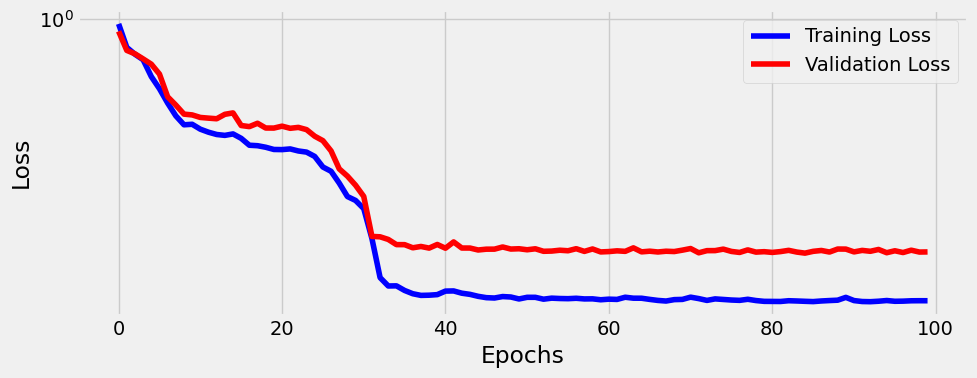

In [81]:
fig = sbs_seq_selfattn.plot_losses()

### Visualizing Predictions

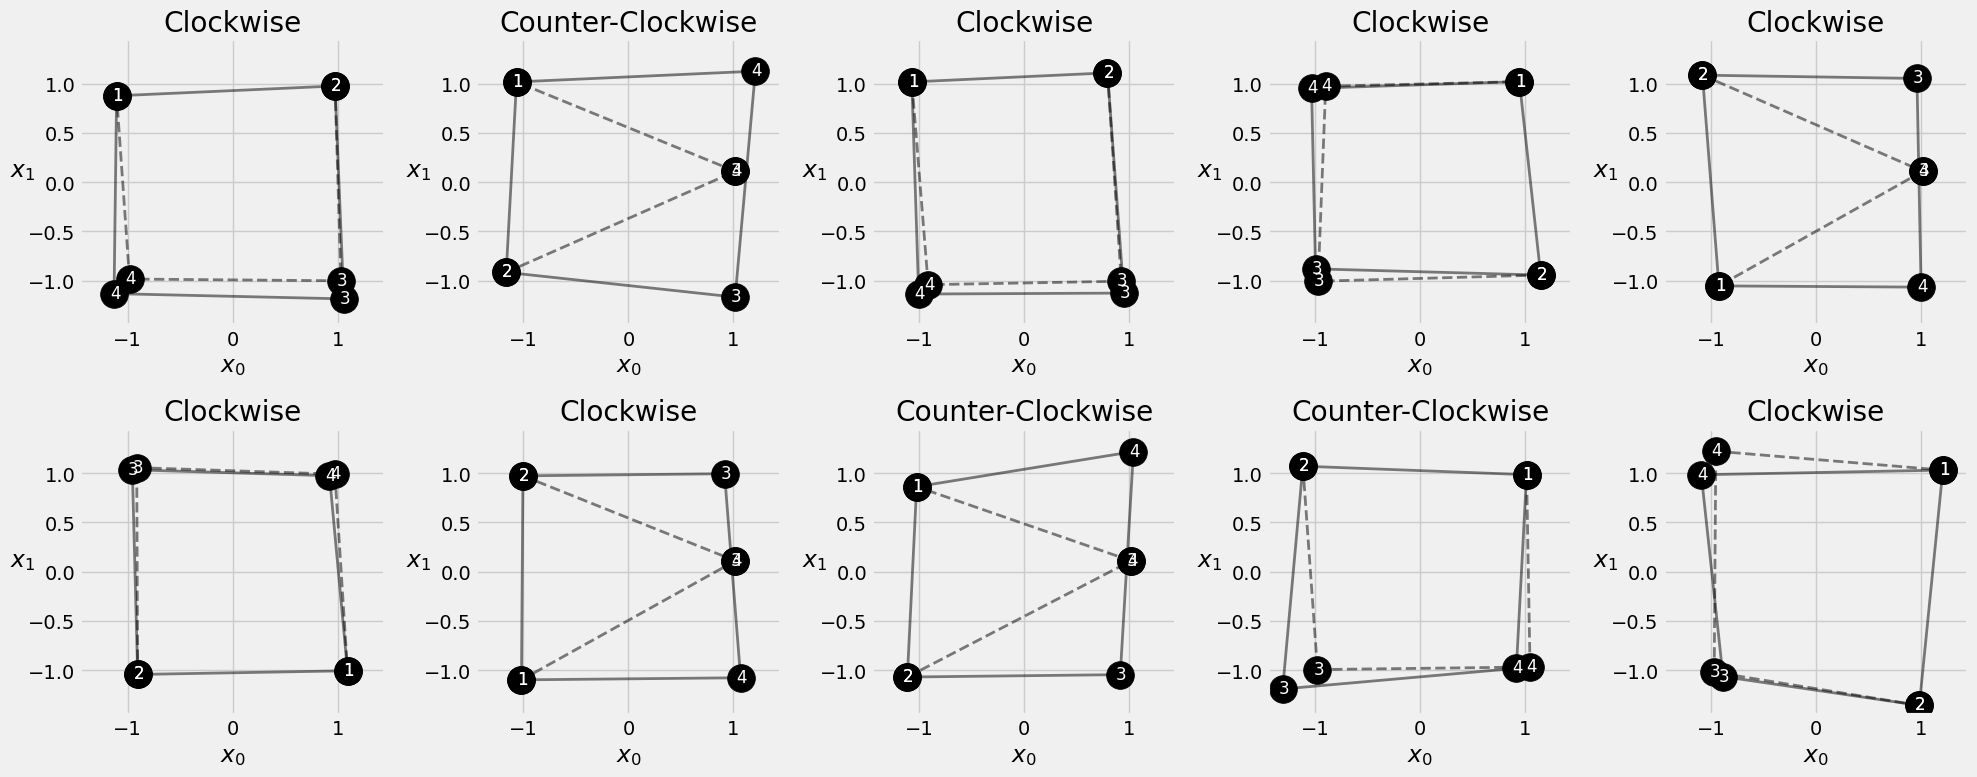

In [82]:
fig = sequence_pred(sbs_seq_selfattn, full_test, test_directions)

### Sequential No More

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoder_lost_seq.png?raw=1)

## Positional Encoding (PE)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_norm4.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_norm4_long.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_mod4mod8.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_modnorm4.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_modnorm_mult.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoded_distances.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_modnorm_deg.png?raw=1)

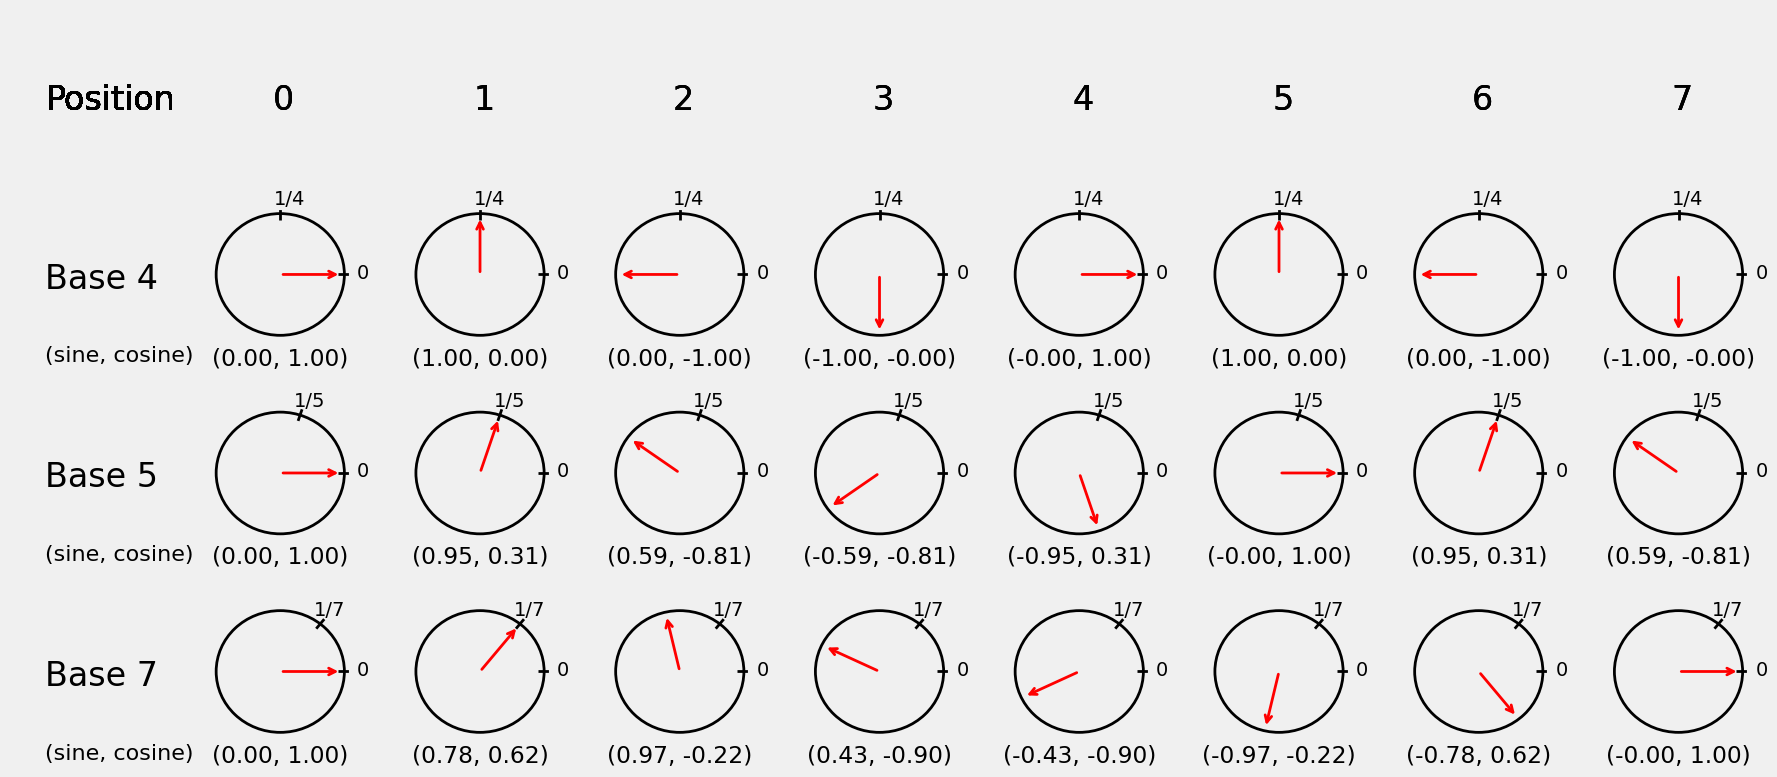

In [83]:
fig = encoding_degrees(dims=3, seqs=(4, 5, 7), tot=8)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_modnorm_sincos.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/sincos_distance.png?raw=1)

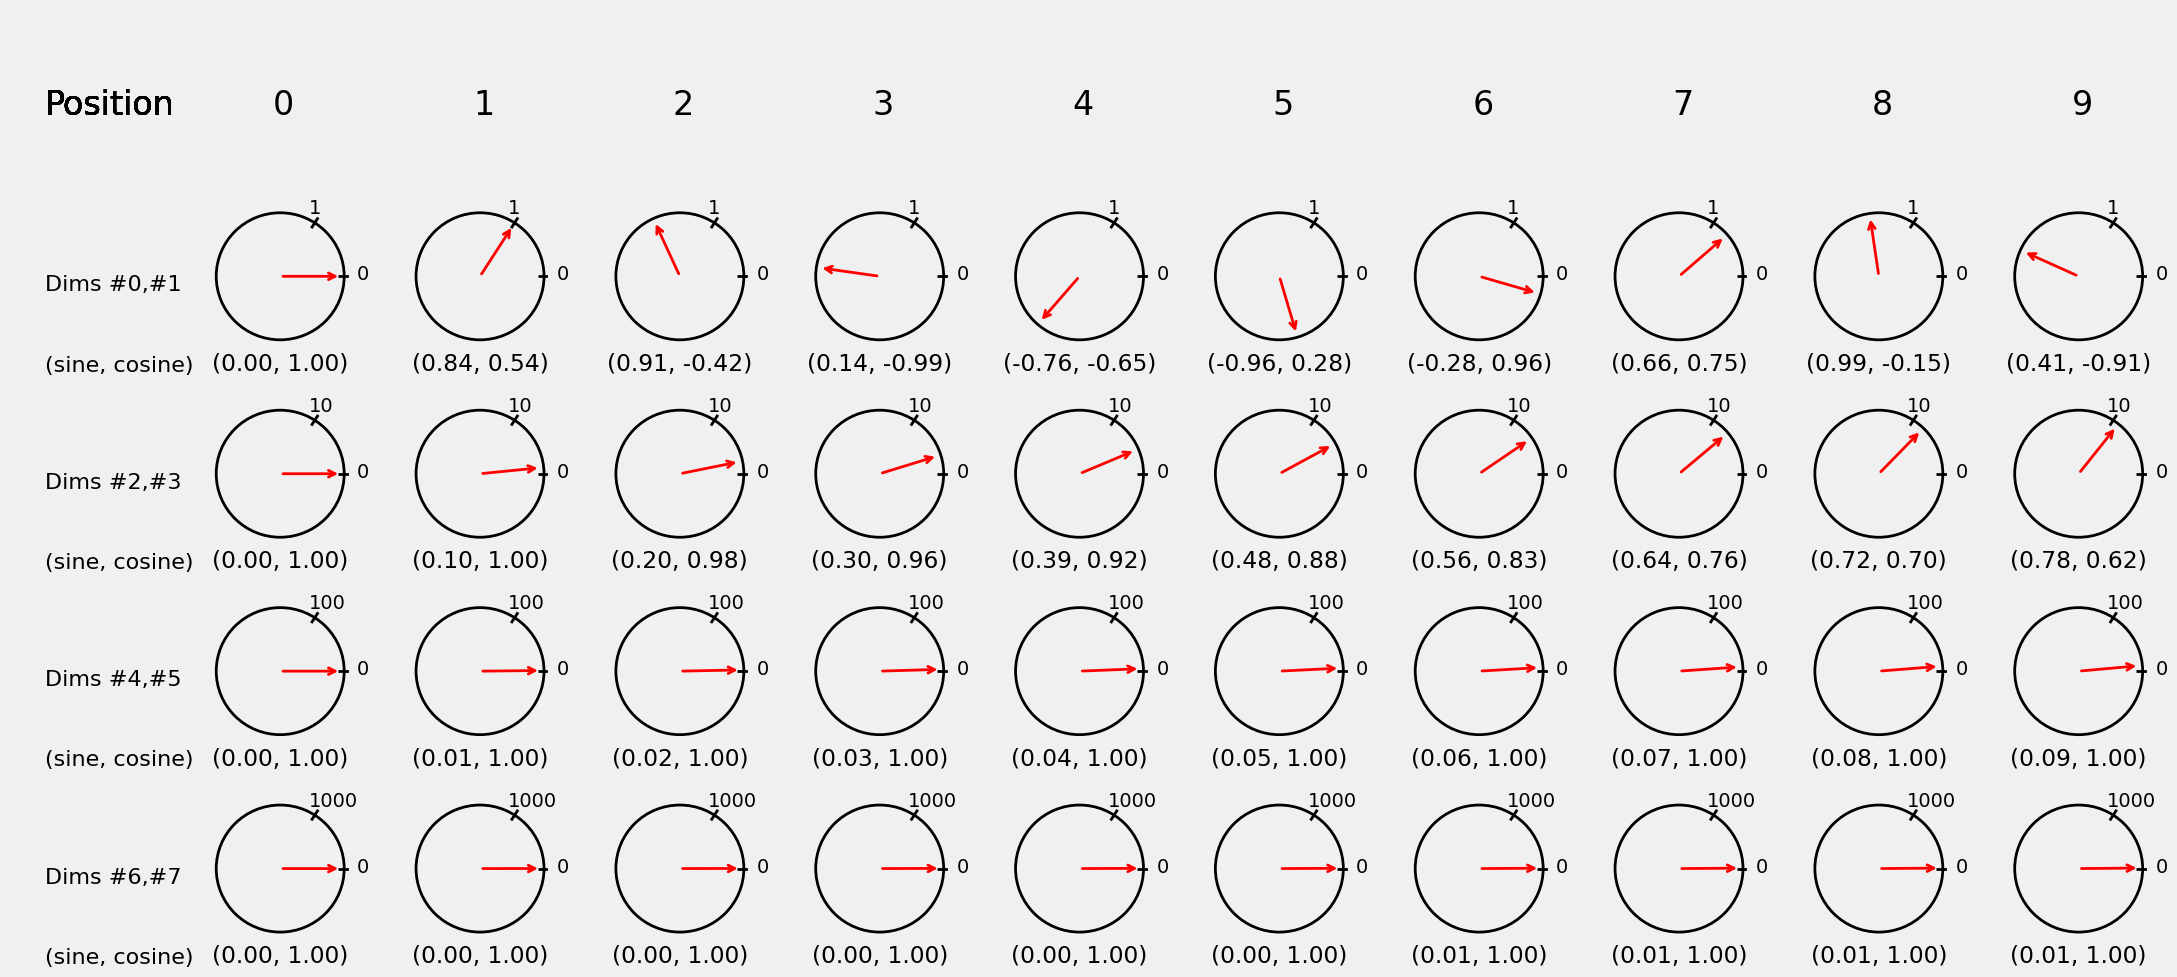

In [84]:
fig = exponential_dials(d_model=8, max_len=10)

$$
\Large
\left(\frac{1}{10000^{\frac{0}{8}}}, \frac{1}{10000^{\frac{2}{8}}}, \frac{1}{10000^{\frac{4}{8}}}, \frac{1}{10000^{\frac{6}{8}}}\right)=(1, 0.1, 0.01, 0.001)
$$

$$
\Large
\text{PE}_{\text{pos},\ 2d} = \text{sin} \left(\frac{1}{10000^{\frac{2d}{d_{\text{model}}}}}\text{pos}\right); \text{PE}_{\text{pos},\ 2d+1} = \text{cos} \left(\frac{1}{10000^{\frac{2d}{d_{\text{model}}}}}\text{pos}\right)
$$

In [85]:
max_len = 10
d_model = 8

position = torch.arange(0, max_len).float().unsqueeze(1)
angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

encoding = torch.zeros(max_len, d_model)
encoding[:, 0::2] = torch.sin(angular_speed * position)
encoding[:, 1::2] = torch.cos(angular_speed * position)

/Users/norman/Data Science/PyTorchStepByStep/plots/chapter9.py:502: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


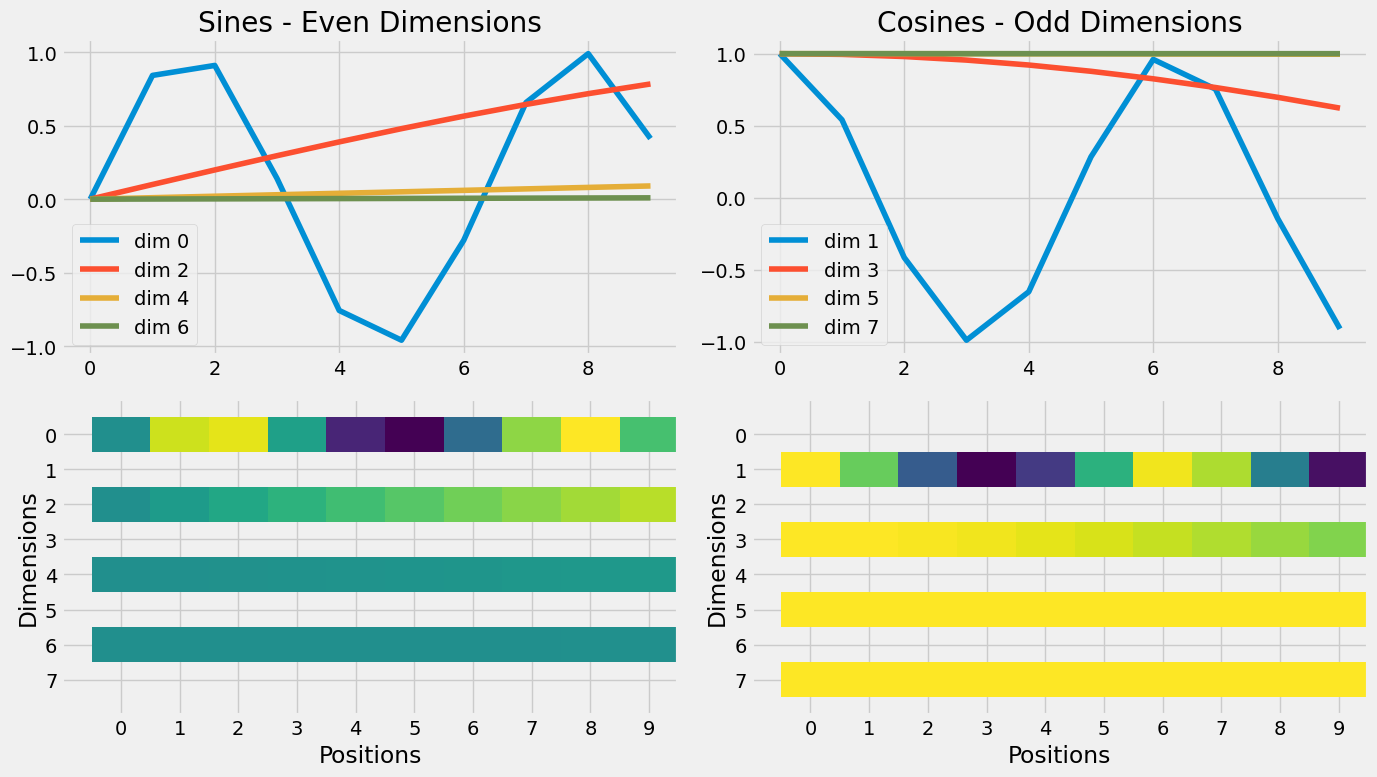

In [86]:
fig = encoding_heatmap(d_model=8, max_len=10)

In [87]:
np.round(encoding[0:4], 4) # first four positions

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0998,  0.9950,  0.0100,  1.0000,  0.0010,  1.0000],
        [ 0.9093, -0.4161,  0.1987,  0.9801,  0.0200,  0.9998,  0.0020,  1.0000],
        [ 0.1411, -0.9900,  0.2955,  0.9553,  0.0300,  0.9996,  0.0030,  1.0000]])

### A Note on Encoded Distances

In [88]:
distances = np.zeros((5, 5))
for i, v1 in enumerate(encoding[:5]):
    for j, v2 in enumerate(encoding[:5]):
        distances[i, j] = np.linalg.norm(v1 - v2)

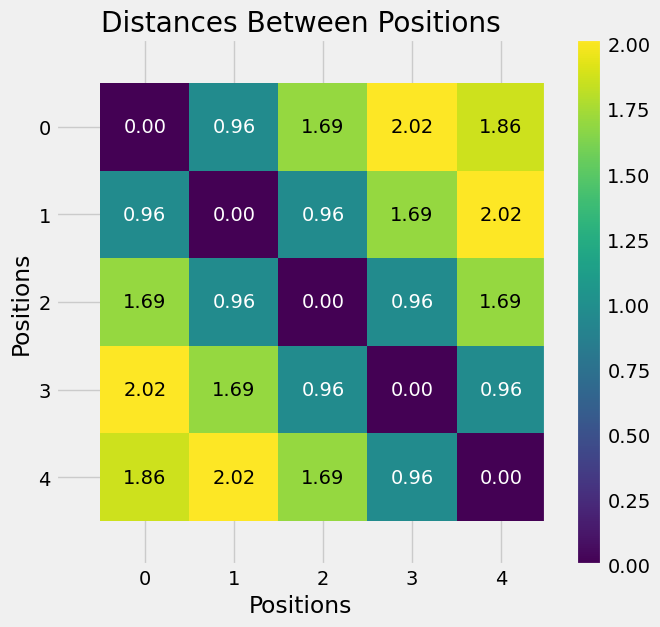

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
ax.set_title('Distances Between Positions')
fig = plot_mesh(distances, ax, showvals=True, colorbar=True, ylabel='Positions')

In [90]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * angular_speed) # even dimensions
        pe[:, 1::2] = torch.cos(position * angular_speed) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

In [91]:
posenc = PositionalEncoding(2, 2)

In [92]:
list(posenc.parameters()), posenc.state_dict()

([],
 OrderedDict([('pe', tensor([[[0.0000, 1.0000],
                        [0.8415, 0.5403]]]))]))

In [93]:
posenc.pe

tensor([[[0.0000, 1.0000],
         [0.8415, 0.5403]]])

In [94]:
source_seq # 1, L, D

tensor([[[-1., -1.],
         [-1.,  1.]]])

In [95]:
source_seq + posenc.pe

tensor([[[-1.0000,  0.0000],
         [-0.1585,  1.5403]]])

$$
\Large
\text{standardized}\ x = \frac{\text{"raw"}\ x}{\sqrt{d_x}} \implies \text{"raw"} x = \sqrt{d_x}\ \text{standardized}\ x
$$

In [96]:
posenc(source_seq)

tensor([[[-1.4142, -0.4142],
         [-0.5727,  1.9545]]])

### Encoder + Decoder + PE

In [97]:
class EncoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = EncoderSelfAttn(n_heads, d_model, ff_units, n_features)
    
    def forward(self, query, mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, mask)
        return out
    
class DecoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = DecoderSelfAttn(n_heads, d_model, ff_units, n_features)
        
    def init_keys(self, states):
        self.layer.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, source_mask, target_mask)
        return out

### Model Configuration & Training

In [98]:
torch.manual_seed(43)
encpe = EncoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)
decpe = DecoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)

model = EncoderDecoderSelfAttn(encpe, decpe, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [99]:
sbs_seq_selfattnpe = StepByStep(model, loss, optimizer)
sbs_seq_selfattnpe.set_loaders(train_loader, test_loader)
sbs_seq_selfattnpe.train(100)

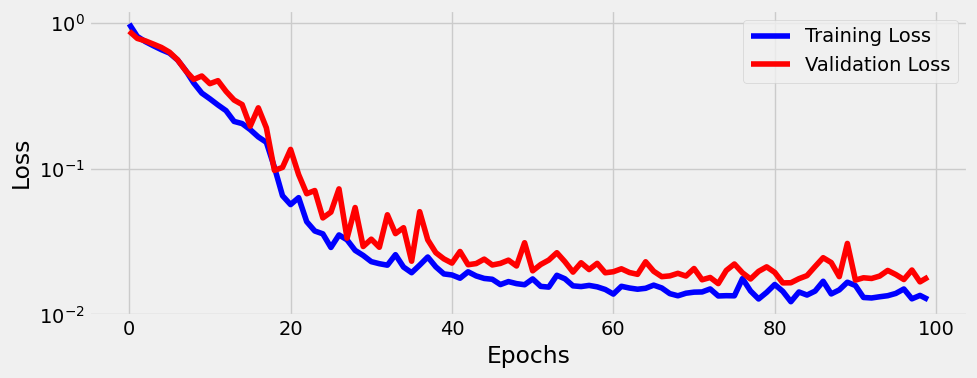

In [100]:
fig = sbs_seq_selfattnpe.plot_losses()

### Visualizing Predictions

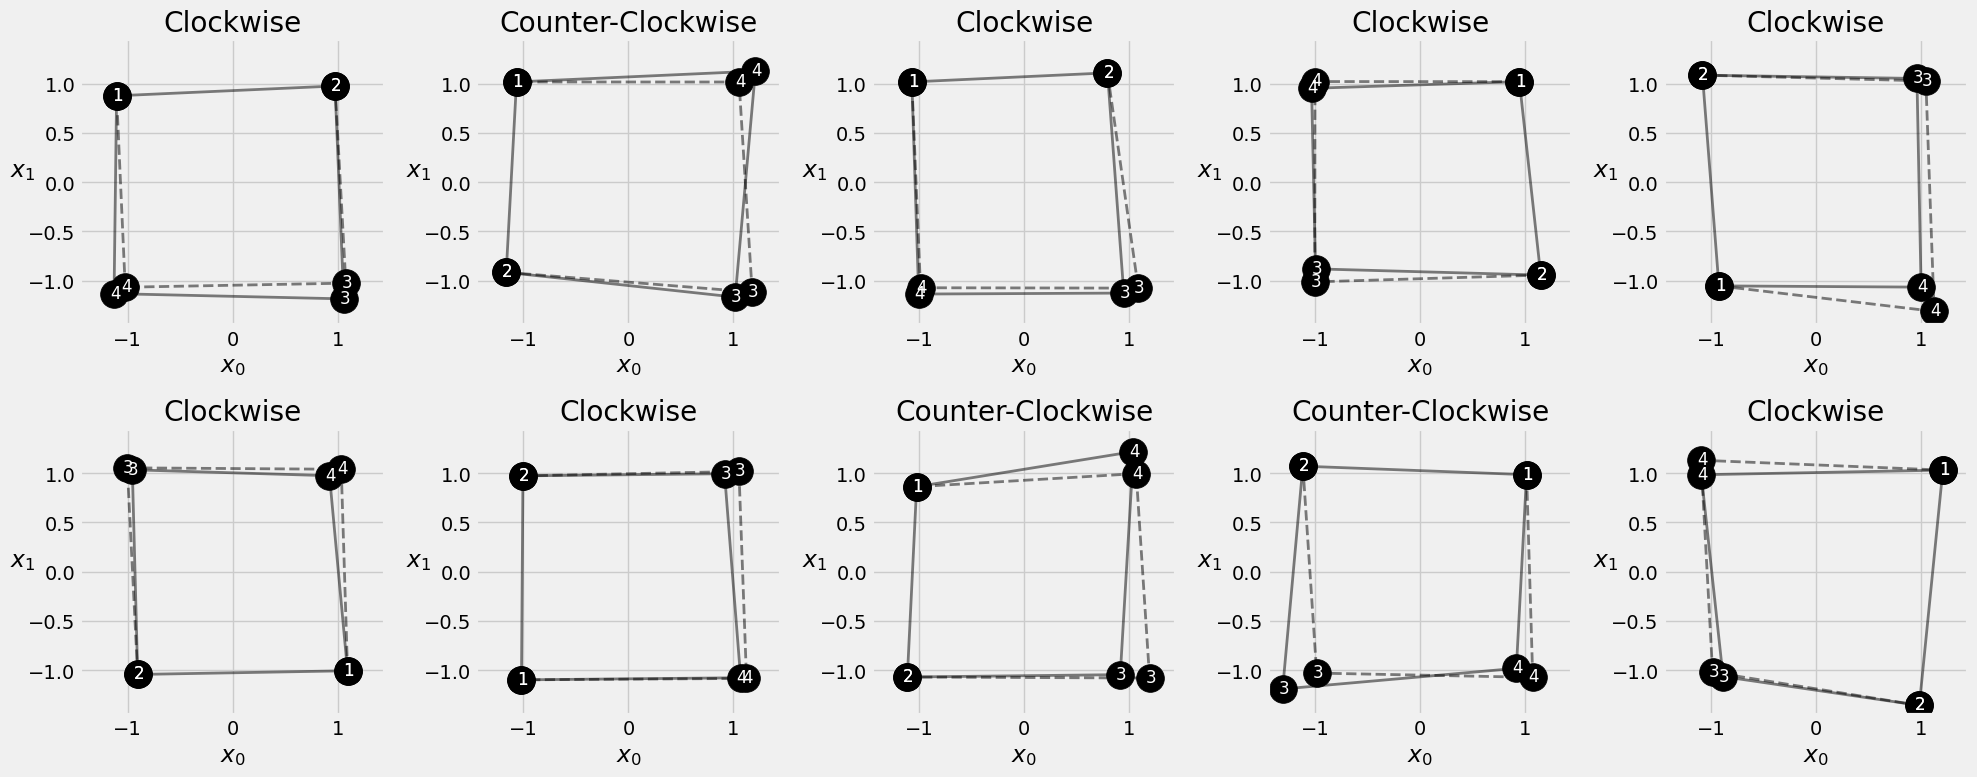

In [101]:
fig = sequence_pred(sbs_seq_selfattnpe, full_test, test_directions)

### Visualizing Attention

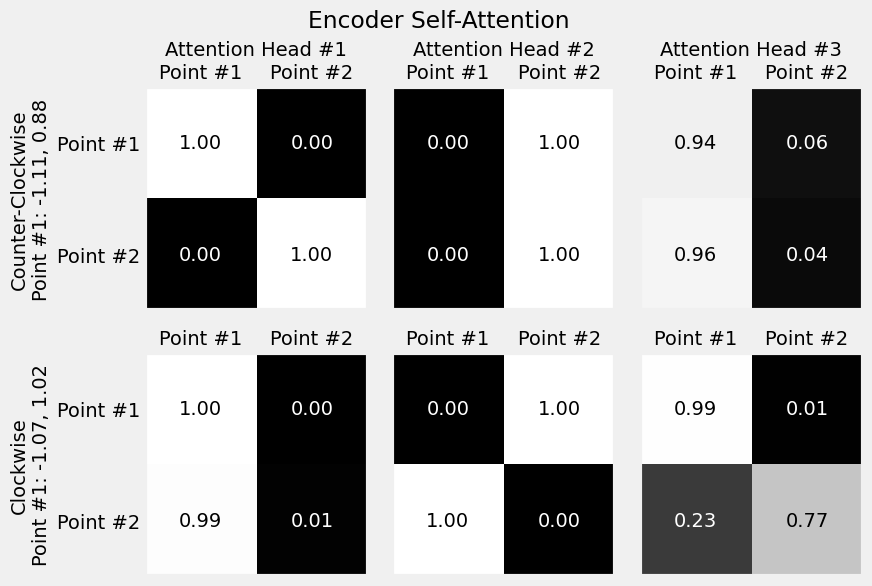

In [102]:
inputs = full_test[:2, :2]
source_labels = ['Point #1', 'Point #2']
target_labels = ['Point #3', 'Point #4']
point_labels = [f'{"Counter-" if not directions[i] else ""}Clockwise\nPoint #1: {inp[0, 0]:.2f}, {inp[0, 1]:.2f}' for i, inp in enumerate(inputs)]

fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, decoder=False, self_attn=True, alphas_attr='encoder.layer.self_attn_heads.alphas')
fig.suptitle('Encoder Self-Attention')
fig.subplots_adjust(top=0.85) 

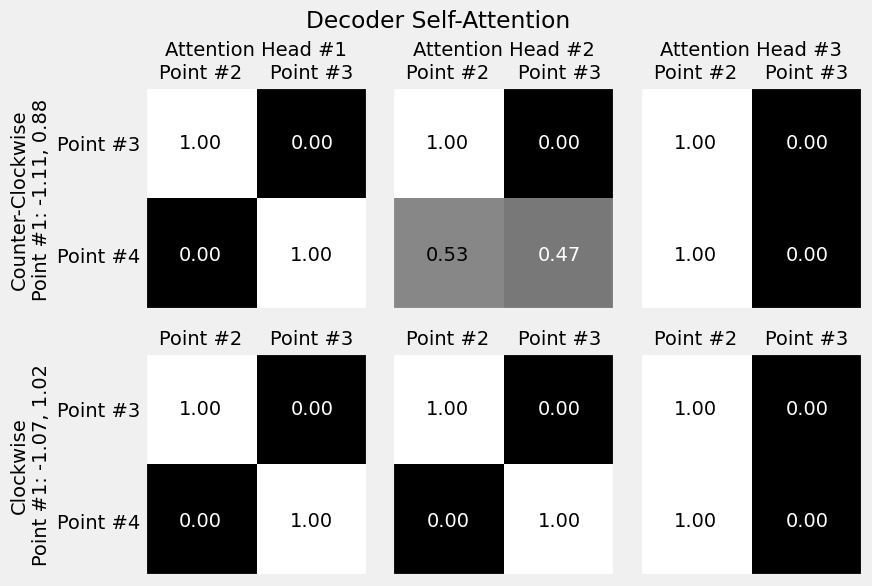

In [103]:
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, 
                     decoder=True, self_attn=True, alphas_attr='decoder.layer.self_attn_heads.alphas')
fig.suptitle('Decoder Self-Attention')
fig.subplots_adjust(top=0.85) 

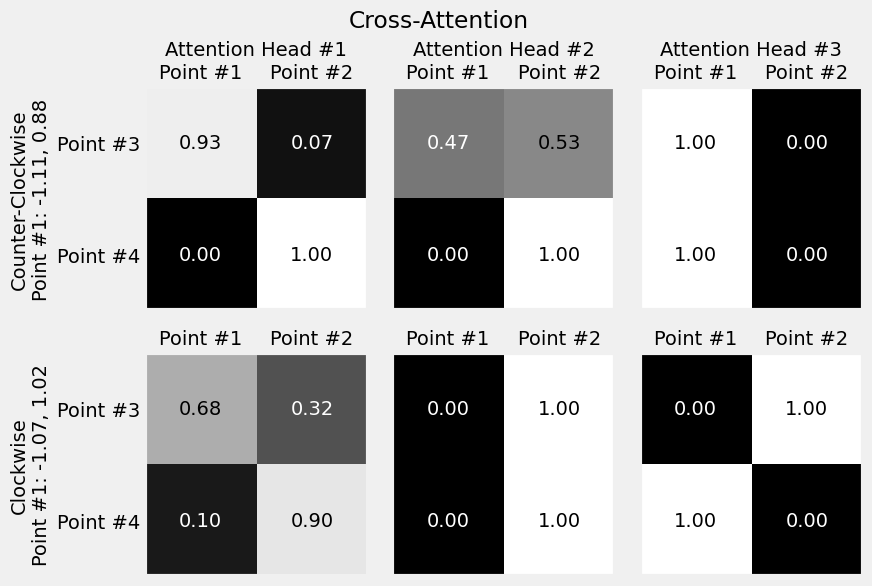

In [104]:
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, self_attn=False, alphas_attr='decoder.layer.cross_attn_heads.alphas')
fig.suptitle('Cross-Attention')
fig.subplots_adjust(top=0.85) 

## Putting It All Together

### Data Preparation

In [105]:
# Training set
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]
train_data = TensorDataset(full_train, target_train)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)

# Validation/Test Set
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]
test_data = TensorDataset(source_test, target_test)
test_loader = DataLoader(test_data, batch_size=16)

### Model Assembly

In [106]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask
                
    def encode(self, source_seq, source_mask):
        # Encodes the source sequence and uses the result
        # to initialize the decoder
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Decodes/generates a sequence using the shifted (masked)
        # target sequence - used in TRAIN mode
        outputs = self.decoder(shifted_target_seq, 
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs
    
    def predict(self, source_seq, source_mask):
        # Decodes/generates a sequence using one input
        # at a time - used in EVAL mode
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        # Sends the mask to the same device as the inputs
        self.trg_masks = self.trg_masks.type_as(X).bool()
        # Slices the input to get source sequence
        source_seq = X[:, :self.input_len, :]
        # Encodes source sequence AND initializes decoder
        self.encode(source_seq, source_mask)
        if self.training:
            # Slices the input to get the shifted target seq
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            # Decodes using the mask to prevent cheating
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            # Decodes using its own predictions
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

### Encoder + Decoder + Positional Encoding

In [107]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * angular_speed) # even dimensions
        pe[:, 1::2] = torch.cos(position * angular_speed) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

class EncoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = EncoderSelfAttn(n_heads, d_model, ff_units, n_features)
    
    def forward(self, query, mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, mask)
        return out
    
class DecoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = DecoderSelfAttn(n_heads, d_model, ff_units, n_features)
        
    def init_keys(self, states):
        self.layer.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, source_mask, target_mask)
        return out

### Self-Attention "Layers"

In [108]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=n_features)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model),
        )
         
    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att = self.self_attn_heads(query, mask)
        out = self.ffn(att)
        return out

class DecoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = d_model if n_features is None else n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=self.n_features)
        self.cross_attn_heads = MultiHeadAttention(n_heads, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, self.n_features),
        )
        
    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)
         
    def forward(self, query, source_mask=None, target_mask=None):
        self.self_attn_heads.init_keys(query)
        att1 = self.self_attn_heads(query, target_mask)
        att2 = self.cross_attn_heads(att1, source_mask)
        out = self.ffn(att2)
        return out

### Attention Heads

In [109]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out = nn.Linear(n_heads * d_model, d_model)
        self.attn_heads = nn.ModuleList([Attention(d_model, 
                                                   input_dim=input_dim, 
                                                   proj_values=proj_values) 
                                         for _ in range(n_heads)])
        
    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)
        
    @property
    def alphas(self):
        # Shape: n_heads, N, 1, L (source)
        return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)
        
    def output_function(self, contexts):
        # N, 1, n_heads * D
        concatenated = torch.cat(contexts, axis=-1)
        out = self.linear_out(concatenated) # N, 1, D
        return out
        
    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out
    
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None
                
    def init_keys(self, keys):
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) \
                      if self.proj_values else self.keys
                
    def score_function(self, query):
        proj_query = self.linear_query(query)
        # scaled dot product
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def forward(self, query, mask=None):
        # Query is batch-first N, 1, H
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()
        
        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

### Model Configuration & Training

In [110]:
torch.manual_seed(43)
encpe = EncoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)
decpe = DecoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)

model = EncoderDecoderSelfAttn(encpe, decpe, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [111]:
sbs_seq_selfattnpe = StepByStep(model, loss, optimizer)
sbs_seq_selfattnpe.set_loaders(train_loader, test_loader)
sbs_seq_selfattnpe.train(100)

In [112]:
sbs_seq_selfattnpe.losses[-1], sbs_seq_selfattnpe.val_losses[-1]

(0.012674545287154615, 0.018068245728500187)